In [2]:
from IPython.core.display import display, HTML,display_html
from IPython.display import display, Markdown, clear_output
from ipywidgets import interact, interact_manual
import ipywidgets as widgets
import itertools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 
import seaborn as sns
%load_ext autoreload
%autoreload 2

Loading Libs

In [3]:
df = pd.read_csv('./Bases/riskCreatorDB.csv')

In [4]:
df.columns

Index(['riskBad', 'riskGood', 'bad_90'], dtype='object')

In [5]:
df.shape

(11910, 3)

In [6]:
#df = df[['riskBad','bad_90','riskGood']]
df.columns = ['riskBad','riskGood','bad']

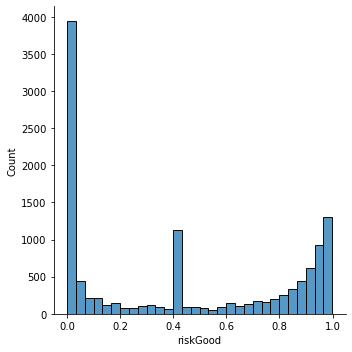

In [9]:
sns.displot(df['riskGood'],bins=30,)

In [60]:
qbins = 30
out, bins = pd.qcut(df['riskGood'],qbins,duplicates='drop', retbins=True)

### Create Groups

In [61]:
def get_bins(x,binz):
    for i in range(len(binz)):
        if i == 0:
            if x <= binz[i]:
                return i
        elif i == len(binz)-1:
            if x >= binz[i]:
                return i+1
            elif x >= binz[i-1] and x < binz[i]:
                return i
        else:
            if x >= binz[i-1] and x < binz[i]:
                return i

In [62]:
def getRating(x):
    rating = ['A1','A2','A3','B1','B2','B3','C1','C2','C3','D1','D2','D3','E','F']
    thresh = [0.03,0.06,0.08,0.1,0.15,0.2,0.25,0.35,0.5,0.6,0.7,0.8,0.9]
    for i in range(len(thresh)):
        if i == 0:
            if x <= thresh[i]:
                return rating[i]
        elif i == len(thresh)-1:
            if x >= thresh[i]:
                return rating[i+1]
            elif x >= thresh[i-1] and x < thresh[i]:
                return rating[i]
        else:
            if x >= thresh[i-1] and x < thresh[i]:
                return rating[i]

In [63]:
def createRiskGroup(df,binz):
    groups = []
    for i in range(1,len(binz)+1):
        try:
            groups.append({
                'group' : i, 'threshold' : binz[i-1] , 
                'bad(%)' : df['bad'][df['risk_group'] == i].value_counts(normalize=True).sort_index().values[1]*100 , 
                'pop(%)' : (df[df['risk_group'] == i].shape[0]/df.shape[0])*100 , 
                'rating' : getRating(df['bad'][df['risk_group'] == i].value_counts(normalize=True).sort_index().values[1]) 
            })
        except:
            groups.append({
                'group' : i, 'threshold' : binz[i-1] , 
                'bad(%)' : 0, 
                'pop(%)' : (df[df['risk_group'] == i].shape[0]/df.shape[0])*100, 
                'rating' : getRating(0) 
            })
    return groups

In [64]:
df['risk_group'] = df['riskGood'].map(lambda x: get_bins(x,bins[1:-1]))
grouped = pd.DataFrame(createRiskGroup(df,bins[1:-1]))

In [65]:
grouped

,group,threshold,bad(%),pop(%),rating
0,1,0.000093,0.000000,2.670025,A1
1,2,0.000183,0.000000,3.467674,A1
2,3,0.000348,0.000000,3.266163,A1
3,4,0.000730,0.000000,3.400504,A1
4,5,0.002314,98.992443,3.333333,F
5,6,0.004720,99.744898,3.291352,F
6,7,0.007114,0.000000,3.324937,A1
7,8,0.012502,98.469388,3.291352,F
8,9,0.019611,98.039216,3.425693,F
9,10,0.035050,96.473552,3.333333,F


### Decision Process

In [80]:
df['risk_group'] = df['riskGood'].map(lambda x: get_bins(x,bins[1:-1]))
grouped = pd.DataFrame(createRiskGroup(df,bins[1:-1]))

changes = 1
while changes != 0:
    newBins = list(grouped['threshold'].values)
    changes = 0
    i = 0
    # kinda recursive
    while i <= grouped.shape[0]-2:
        
        if grouped.loc[i+1,'bad(%)'] > 35:
            
            if grouped.loc[i,'rating'] == grouped.loc[i+1,'rating']:
                
                newBins.remove(grouped.loc[i+1,'threshold'])
                i = i + 1
                changes = changes + 1
                
                print(1)
            
            elif np.abs(grouped.loc[i,'bad(%)'] - grouped.loc[i+1,'bad(%)']) < 15 and (grouped.loc[i,'pop(%)'] + grouped.loc[i+1,'pop(%)']) < 15 and grouped.loc[i+1,'bad(%)'] > 2:
                
                #print('3 - Dropping',str(grouped.loc[i,'threshold']),'Leaving',str(grouped.loc[i+1,'threshold']))
                
                newBins.remove(grouped.loc[i,'threshold'])
                i = i + 1
                changes = changes + 1
                
                print(2)
                
            elif grouped.loc[i,'bad(%)'] < grouped.loc[i+1,'bad(%)']:
                
                newBins.remove(grouped.loc[i+1,'threshold'])
                i = i + 1
                changes = changes + 1
                
                print(3)
                
            else:
                pass
                
        else:
            
            if grouped.loc[i,'rating'] == grouped.loc[i+1,'rating']:
                
                newBins.remove(grouped.loc[i+1,'threshold'])
                i = i + 1
                changes = changes + 1
                
                print(4)
                
            elif grouped.loc[i,'bad(%)'] < grouped.loc[i+1,'bad(%)']:
                
                newBins.remove(grouped.loc[i,'threshold'])
                i = i + 1
                changes = changes + 1
                
                print(5)
            
            elif (grouped.loc[i,'pop(%)']) < 2 and np.abs(grouped.loc[i,'bad(%)'] - grouped.loc[i+1,'bad(%)']) < grouped.loc[i+1,'bad(%)']/10 and grouped.loc[i+1,'bad(%)'] < 2:
                
                #print('0 - Dropping',str(grouped.loc[i,'threshold']),'Leaving',str(grouped.loc[i+1,'threshold']))
                
                newBins.remove(grouped.loc[i,'threshold'])
                i = i + 1
                changes = changes + 1
                
                print(6)
                
            elif np.abs(grouped.loc[i,'bad(%)'] - grouped.loc[i+1,'bad(%)']) < grouped.loc[i+1,'bad(%)']/10 and (grouped.loc[i,'pop(%)'] + grouped.loc[i+1,'pop(%)']) < 10 and  grouped.loc[i+1,'bad(%)'] > 2:
                
                #print('1 - Dropping',str(grouped.loc[i,'threshold']),'Leaving',str(grouped.loc[i+1,'threshold']))
                
                newBins.remove(grouped.loc[i,'threshold'])
                i = i + 1
                changes = changes + 1
                
                print(7)
                
            elif grouped.loc[i,'bad(%)'] < grouped.loc[i+1,'bad(%)']:
                
                #print('1 - Dropping',str(grouped.loc[i,'threshold']),'Leaving',str(grouped.loc[i+1,'threshold']))
                
                newBins.remove(grouped.loc[i,'threshold'])
                i = i + 1
                changes = changes + 1
                
                print(8)
                
            else:
                pass
        
        if i <= grouped.shape[0]:
            i = i + 1
        
    newBins = sorted(list(set(newBins+[0])))
    df['risk_group'] = df['riskGood'].map(lambda x: get_bins(x,newBins))
    grouped = pd.DataFrame(createRiskGroup(df,newBins))
    #display(grouped)
grouped

4
4
1
3
1
2
2
2
4
4
4
4
4
3
1
2
4
3
1


,group,threshold,bad(%),pop(%),rating
0,1,0.000000,98.845508,40.000000,F
1,2,0.121623,63.979849,16.666667,D2
2,3,0.446275,49.874055,3.333333,C3
3,4,0.607372,32.241814,3.333333,C2
4,5,0.706547,21.039290,6.624685,C1
5,6,0.836804,12.935323,3.375315,B2
6,7,0.878725,9.823678,3.333333,B1
7,8,0.903097,7.215190,6.633081,A3
8,9,0.942909,4.267782,10.033585,A2
9,10,0.978751,0.377834,6.666667,A1


In [81]:
def printThresholds(binz):
    print('def get_bins(x):')
    for i in range(len(binz)):
        if i == 0:
            print('\tif x <=',np.round(binz['threshold'][i+1],5),':')
            print('\t\treturn',i+1,',"'+binz['rating'][i]+'"')
        elif i == len(binz)-1:
            print('\telif x > ',np.round(binz['threshold'][i],5),':')
            print('\t\treturn',i+1,',"'+binz['rating'][i]+'"')
        else:
            print('\telif x > ',np.round(binz['threshold'][i],5),'and  x <= ',np.round(binz['threshold'][i+1],4),':')
            print('\t\treturn',i+1,',"'+binz['rating'][i]+'"')

In [82]:
printThresholds(grouped[['threshold','rating']].sort_values('threshold'))

def get_bins(x):
	if x <= 0.12162 :
		return 1 ,"F"
	elif x >  0.12162 and  x <=  0.4463 :
		return 2 ,"D2"
	elif x >  0.44628 and  x <=  0.6074 :
		return 3 ,"C3"
	elif x >  0.60737 and  x <=  0.7065 :
		return 4 ,"C2"
	elif x >  0.70655 and  x <=  0.8368 :
		return 5 ,"C1"
	elif x >  0.8368 and  x <=  0.8787 :
		return 6 ,"B2"
	elif x >  0.87872 and  x <=  0.9031 :
		return 7 ,"B1"
	elif x >  0.9031 and  x <=  0.9429 :
		return 8 ,"A3"
	elif x >  0.94291 and  x <=  0.9788 :
		return 9 ,"A2"
	elif x >  0.97875 :
		return 10 ,"A1"


FIM